In [26]:
from cosmic import MC_samp
import numpy as np
import pandas as pd
import GW_calcs
import MW_maker
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from IPython.display import clear_output

# Constants
Rsun_au = 1/215.032
day_yr = 1/365.25
yr_sec = 3.155e7
G = 6.67e-11
c = 2.998e+8
Msun = 1.989e30
parsec = 3.086e+19

data_path = './DATA/'
dat_save_path = './DATA/'
Tobs=8
SNR_lim = 7

In [27]:
# ============================================
# Import GWGC & Calculated LISA Power Spectrum
# ============================================

# Import GWGC cataglorized table
GWGC_original = pd.read_csv(data_path + 'GWGC_COMPLETE_Categorized.csv')
GWGC_original = GWGC_original.drop(['Unnamed: 0'], axis=1)

# Exclude Globular Clusters
GWGC = GWGC_original.loc[GWGC_original.Dist>4]
GWGC = GWGC.append(GWGC_original[32160:32161]) #Add back M31
print('Exclude Globular Clusters:', len(GWGC_original)-len(GWGC))
#print(GWGC)

print('=====================================================',)

# =========================================================
# Compute the total gravitational radiation power for Group
# =========================================================

# Galaxy categorization
'''
Have base-model the LISA Gravitational radiation power spectrum:
1. Luminosity distance = 1000 kpc = 1 Mpc, notice GWGC unit in Mpc
2. Galaxy stellar mass = 1e10 solar mass
'''

# Group GWGC following the categorization method
# (Save an additinoal loop)
GWGC_G1 = GWGC.loc[GWGC.GROUP == 1]
GWGC_G2 = GWGC.loc[GWGC.GROUP == 2]
GWGC_G3 = GWGC.loc[GWGC.GROUP == 3]
GWGC_G4 = GWGC.loc[GWGC.GROUP == 4]

# Reset index of GWGC group tables
# Important! Otherwise for-loop won't run
GWGC_G1 = GWGC_G1.reset_index()
GWGC_G2 = GWGC_G2.reset_index()
GWGC_G3 = GWGC_G3.reset_index()
GWGC_G4 = GWGC_G4.reset_index()

print('Number of members in the group:',
      len(GWGC_G1), len(GWGC_G2), len(GWGC_G3), len(GWGC_G4))

Exclude Globular Clusters: 163
Number of members in the group: 1383 38376 6130 3132


Sample data of Gravitational Wave Galaxy Catalog(GWGC) by White et al. 2010

GWGC Parameters:
1. PGC: Identifier from HYPERLEDA
2. Name: Common Galaxy Name
3. RA: Right ascension [hour]
4. DEC: Declination [degree]
5. TT: Galaxy Morphological Type [Hubble Sequence]
6. Bmag: Blue magnitude
7. Dist: Luminosity Distance [Mpc]

Computed data:
8. EST_STELLAR_M: Estimated galaxy stellar mass[$M_{odot}]
9. EST_Z: Estimated galaxy metallicity
10. Categorization label

                  f_gw       strain_2
28        2.109350e-07   4.173795e-53
29        2.148970e-07   6.688151e-53
30        2.188590e-07   3.393540e-52
31        2.228209e-07   3.819089e-52
32        2.267829e-07   4.773341e-52
...                ...            ...
25171735  9.972964e-02  1.845945e-225
25173133  9.973518e-02  2.387445e-179
25219365  9.991834e-02  2.329052e-226
25234831  9.997962e-02  2.303656e-269
25239974  1.000000e-01  1.464480e-156

[389084 rows x 2 columns]
High frequency binaries: 19045 || 0.0489 of total


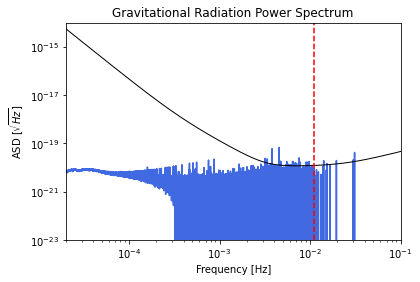

389084


In [28]:
'''
For comparison purpose
Not nessesary to run this cell
'''
# ==============================================
# Power spectrum for base-model fixed population
# Check with galaxy power spectrum below
# ==============================================

# Import Gravitational Wave power spectrum data
power_file = 'glx_power_1.h5'

LISA_power = pd.read_hdf(data_path + power_file, key='power')
LISA_power = LISA_power[LISA_power['strain_2'] != 0]
print(LISA_power)

f_high = 1.1e-2

LISA_power_highf = LISA_power[LISA_power['f_gw'] >= f_high]
print('High frequency binaries:', len(LISA_power_highf), '||',
      format(len(LISA_power_highf)/len(LISA_power), '.4f'), 'of total')

LISA_PSD = GW_calcs.lisa_PSD()

plt.plot(LISA_power.f_gw, (LISA_power.strain_2*Tobs*yr_sec)**0.5, color='royalblue', rasterized=True)
plt.plot(np.linspace(5e-6, 0.1, 10000), 
        (LISA_PSD(np.linspace(5e-6, 0.1, 10000)))**0.5, lw=1, color='black')

plt.axvline(x=f_high, color='r', linestyle='--')

plt.xscale('log')
plt.yscale('log')
plt.xlim(2e-5, 1e-1)
plt.ylim(1e-23, 1e-14)
plt.xlabel('Frequency [Hz]')
plt.ylabel('ASD [$\sqrt{Hz}$]')
plt.title('Gravitational Radiation Power Spectrum')

plt.show()
print(len(LISA_power))

Compute Group Power Spectrum
==

In [ ]:
# ==============================
# Galaxy group power computation
# ==============================


# Import Initial Four Baseline Galaxy Power Data
power_file_i_1 = pd.read_hdf(data_path + 'glx_power_1.h5', key='power')
power_file_i_2 = pd.read_hdf(data_path + 'glx_power_2.h5', key='power')
power_file_i_3 = pd.read_hdf(data_path + 'glx_power_3.h5', key='power')
power_file_i_4 = pd.read_hdf(data_path + 'glx_power_4.h5', key='power')
power_file_i = [power_file_i_1, power_file_i_2, power_file_i_3, power_file_i_4] # <<<<<< check

# Discard Low Power Bins
power_file_1 = power_file_i_1[power_file_i_1['strain_2'] > 1e-65]
power_file_2 = power_file_i_2[power_file_i_2['strain_2'] > 1e-65]
power_file_3 = power_file_i_3[power_file_i_3['strain_2'] > 1e-65]
power_file_4 = power_file_i_4[power_file_i_4['strain_2'] > 1e-65]
power_file = [power_file_1, power_file_2, power_file_3, power_file_4]           # <<<<<< check

# Call Galaxy Catalog
group_glx_file = [GWGC_G1, GWGC_G2, GWGC_G3, GWGC_G4]

print('Power and GWGC data loaded.', '\n')
print('Binaries in the initial population:',
      len(power_file_i_1), 
      len(power_file_i_2), 
      len(power_file_i_3), 
      len(power_file_i_4),)
print('Binaries in the ajusted population:',
      len(power_file_1), 
      len(power_file_2), 
      len(power_file_3), 
      len(power_file_4),)

# Set saving path
save_data_path = './DATA/'
save_file_names = ['group1_power_tot', 
                   'group2_power_tot', 
                   'group3_power_tot', 
                   'group4_power_tot']

print('\n', '==============================',
      '==============================', '\n')


# ===============================
# Generating Group power
# This might take a while 
# (~10 min on Northwestern Quest)
# ===============================

print('Begin computing group power.',
      'This might take a while. (~10 min)', '\n')

j = 0
while j <= 3:
    
    d_power = power_file_i[j]
    d_group = group_glx_file[j]
    save_file_name = save_file_names[j]
    
    print('Computing accumulated power for group', j+1,
          ' | Galaxy memebers:', len(d_group))
    
    # Scale to stellar mass and distanec
    scale_rate = d_group['EST_STELLAR_M']/1e10 / (d_group['Dist'])**2

    # Set an empty total power table
    g_power_tot = d_power*0
    g_power_tot['f_gw'] = d_power['f_gw']

    # ===========================
    # === Compute Group Power ===
    # ===========================
    print('GW Power accumulating...')
    
    i = 0
    for i in range(len(d_group)):
    
        #clear_output(wait=True)
    
        g_power_tot['strain_2'] = g_power_tot['strain_2'] + d_power['strain_2']*scale_rate[i]
        print('Complete:', format(i/len(d_group)*100, '.1f')+'%', end='\r') # print progress

    print('Maximum Scale Rate', format((max(scale_rate)), '.4f'))

    g_power_tot.to_hdf(save_data_path + save_file_name + '.h5', key='power')
    print('Group', j+1, 'done.',
          'File saved as:', save_file_name, '\n')
    
    j = j+1

print('All group power computation done!')

Power and GWGC data loaded. 

Binaries in the initial population: 25239975 25239975 25239975 25239975
Binaries in the working population: 263077 485038 251682 272399

 ============================== ============================== 

Begin computing group power. This might take a while. (~10 min) 

Computing accumulated power for group 1  | Galaxy memebers: 1383
GW Power accumulating...
Maximum Scale Rate 0.4517
Group 1 done. File saved as: group1_power_tot 

Computing accumulated power for group 2  | Galaxy memebers: 38376
GW Power accumulating...
Maximum Scale Rate 1.8481
Group 2 done. File saved as: group2_power_tot 

Computing accumulated power for group 3  | Galaxy memebers: 6130
GW Power accumulating...


Data imported. 

Plot 1 done.
Plot 2 done.
Plot 3 done.
Plot 4 done.
Group Power Spectrum Figure Saved.


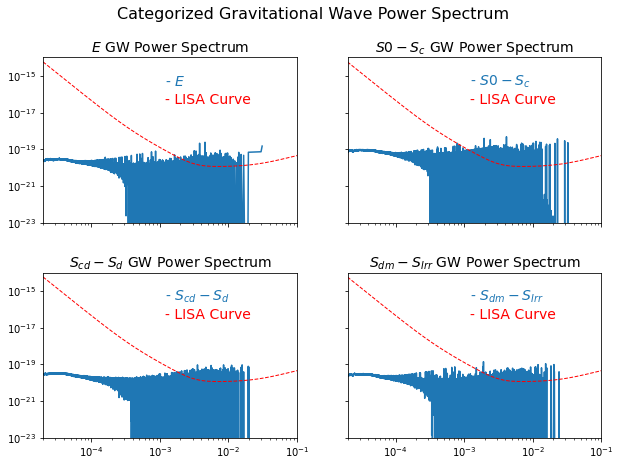

Computing Full Power Spectrum...
Group binaries: 263077 485038 251682 272399 
 Total binaries: 1272196
File saved as: full_power_tot.h5
Full Power Spectrum Figure Saved


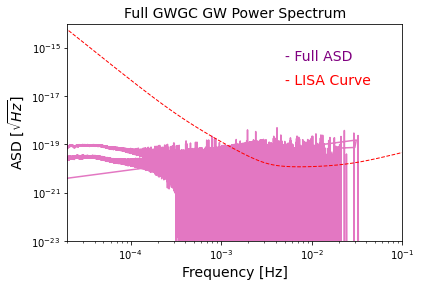

In [102]:
# =====================================
# Plotting Un-randomized Power Spectrum
# (Group and total)
# =====================================

# Import Data
LISA_PSD = GW_calcs.lisa_PSD()
g1_power_tot = pd.read_hdf(data_path + 'group1_power_tot.h5', key='power')
g2_power_tot = pd.read_hdf(data_path + 'group2_power_tot.h5', key='power')
g3_power_tot = pd.read_hdf(data_path + 'group3_power_tot.h5', key='power')
g4_power_tot = pd.read_hdf(data_path + 'group4_power_tot.h5', key='power')
print('Data imported.', '\n')

# Figure Parameters
fs = 14 # fontsize
fig, ((ax1, ax2), 
      (ax3, ax4)) = plt.subplots(2, 2, sharey = False, 
                                 gridspec_kw={'hspace': 0.3, 'wspace': 0.2}, figsize = (10, 7))
fig.suptitle('Categorized Gravitational Wave Power Spectrum', fontsize = fs+2)

# Plotting Style
g_powers = [g1_power_tot, g2_power_tot, g3_power_tot, g4_power_tot]
glx_names = ['$E$', '$S0 - S_c$', '$S_{cd} - S_d$','$S_{dm} - S_{Irr}$']
axs = [ax1, ax2, ax3, ax4]
text_x = 1.2e-3 # text location
text_y_up = 3e-16 # text location
text_y_dn = 3e-17 # text location
fs = 14 # fontsize

# Plot the Grid
for i in range(4):
    axs[i].plot(g_powers[i].f_gw, 
               (g_powers[i].strain_2*Tobs*yr_sec)**0.5, color='tab:blue', rasterized=True)
    axs[i].plot(np.linspace(5e-6, 0.1, 10000), 
               (LISA_PSD(np.linspace(5e-6, 0.1, 10000)))**0.5, lw=1, linestyle='--', color='red')
    axs[i].set_title(glx_names[i]+' GW Power Spectrum', fontsize=fs)
    axs[i].text(text_x, text_y_up, 
                r'- '+glx_names[i], color = 'tab:blue', fontsize=fs)
    axs[i].text(text_x, text_y_dn, 
                r'- LISA Curve', color = 'red', fontsize=fs)
    print('Plot', i+1, 'done.')

for ax in fig.get_axes():
    ax.label_outer()
    ax.set_xlim(2e-5, 1e-1)
    ax.set_ylim(1e-23, 1e-14)
    ax.set_xscale('log')
    ax.set_yscale('log')

save_plot_name = 'Group_GW_power_spec'
plt.savefig('figures/' + save_plot_name + '.png')
print('Group Power Spectrum Figure Saved.')
plt.show()


# ======================
# Comoputing Total Power
# ======================
print('Computing Full Power Spectrum...')

# Combine all group spectrum
full_power_tot = pd.concat([g1_power_tot, g2_power_tot, g3_power_tot, g4_power_tot])
full_power_tot.sort_values(by=['f_gw'])
print('Group binaries:',
      len(g1_power_tot), len(g2_power_tot), len(g3_power_tot), len(g4_power_tot), '\n',
      'Total binaries:',
      len(full_power_tot))

# Save Data
save_data_path = './DATA/'
full_power_tot.to_hdf(save_data_path + 'full_power_tot' + '.h5', key='power')
print('File saved as:', 'full_power_tot.h5')

# Plotting Total Power
plt.plot(full_power_tot.f_gw, 
        (full_power_tot.strain_2*Tobs*yr_sec)**0.5, color='tab:pink', rasterized=True)
plt.plot(np.linspace(5e-6, 0.1, 10000), 
            (LISA_PSD(np.linspace(5e-6, 0.1, 10000)))**0.5, lw=1, linestyle='--', color='red')

# Plotting Styles
plt.xscale('log')
plt.yscale('log')
plt.xlim(2e-5, 1e-1)
plt.ylim(1e-23, 1e-14)
plt.xlabel('Frequency [Hz]', fontsize=fs)
plt.ylabel('ASD [$\sqrt{Hz}$]', fontsize=fs)

plt.text(0.5e-2, 3e-16, 
         r'- Full ASD', color = 'purple',
         fontsize=fs)
plt.text(0.5e-2, 3e-17, 
         r'- LISA Curve', color = 'red',
         fontsize=fs)
plt.title('Full GWGC GW Power Spectrum',
         fontsize=fs)

save_plot_name = 'Full_GW_power_spec'
plt.savefig('figures/' + save_plot_name + '.png')
print('Full Power Spectrum Figure Saved')
plt.show()

High Frequency Power Randomization
==

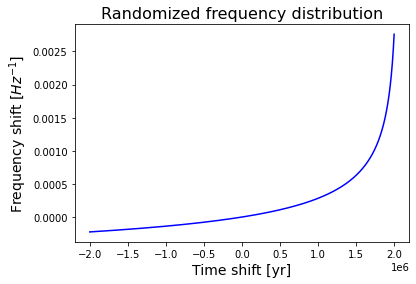

In [103]:
# ===============================================
# Frequency shift & Birth time shift Relationship
# ===============================================

# Randomized frequency distribution
def f_shift(M_c, f_gw, t_shift):
    kappa = 153/3*np.pi**(8/3)*G**(5/3)*c**(-5)
    return np.abs(f_gw**(-8/3) - kappa*M_c**(5/3)*t_shift*yr_sec)**(-3/8) - f_gw

# Visulize randomized frequency distribution
t_shift = np.linspace(-2e6, 2e6, 100000) # (t_shift upper limit ~2e6)
plt.plot(t_shift, f_shift(M_c=Msun, f_gw=1e-3, t_shift=t_shift),
        lw=1.5, linestyle='-', color='b')

fs=14 # fontsize
plt.xlabel('Time shift [yr]', fontsize=fs)
plt.ylabel('Frequency shift [$Hz^{-1}$]', fontsize=fs)
plt.title('Randomized frequency distribution', fontsize=fs+2)
plt.show()

In [110]:
# ===============================================
# High Frequency Galaxy Group Power Randomization
# Generating Group power
# This might take a while 
# (~10 min on Northwestern Quest)
# ===============================================


# Import GWGC and Four Baseline Galaxy Power Data
group_glx_file = [GWGC_G1, GWGC_G2, GWGC_G3, GWGC_G4]

# Discard empty frequency bins
power_file_1 = pd.read_hdf(data_path + 'glx_power_1.h5', key='power')
power_file_1 = power_file_1[power_file_1['strain_2'] > 1e-65]
power_file_2 = pd.read_hdf(data_path + 'glx_power_2.h5', key='power')
power_file_2 = power_file_2[power_file_2['strain_2'] > 1e-65]
power_file_3 = pd.read_hdf(data_path + 'glx_power_3.h5', key='power')
power_file_3 = power_file_3[power_file_3['strain_2'] > 1e-65]
power_file_4 = pd.read_hdf(data_path + 'glx_power_4.h5', key='power')
power_file_4 = power_file_4[power_file_4['strain_2'] > 1e-65]

power_file = [power_file_1, 
              power_file_2, 
              power_file_3, 
              power_file_4]

print('Power and GWGC data loaded.', '\n',
      'Members in the group:',
      len(GWGC_G1), len(GWGC_G2), len(GWGC_G3), len(GWGC_G4), '\n',
      'Binaries in the baseline galaxies:',
      len(power_file_1), 
      len(power_file_2), 
      len(power_file_3), 
      len(power_file_4), '\n',
      '===========================================================', '\n')

# Select the high frequency binaries
f_high = 1e-2
power_file_1_highf = power_file_1[power_file_1['f_gw'] >= f_high]
power_file_2_highf = power_file_2[power_file_2['f_gw'] >= f_high]
power_file_3_highf = power_file_3[power_file_3['f_gw'] >= f_high]
power_file_4_highf = power_file_4[power_file_4['f_gw'] >= f_high]

power_file_highf = [power_file_1_highf,
                    power_file_2_highf, 
                    power_file_3_highf, 
                    power_file_4_highf]

print('High frequency binaries loaded.', '\n',
      'High f binaries in the baseline galaxies:',
      len(power_file_1_highf), 
      len(power_file_2_highf), 
      len(power_file_3_highf), 
      len(power_file_4_highf), '\n',
      '===========================================================', '\n')

# Set saving path
save_data_path = './DATA/'
save_file_names = ['group1_power_tot_rand', 
                   'group2_power_tot_rand', 
                   'group3_power_tot_rand', 
                   'group4_power_tot_rand']


# ===================
# Compute Group Power
# ===================

# Randomization Parameter
t_shift = 1      # <<<<<<<< Time shifting (yr)
glx_sample = 500 # <<<<<<<< Number of galaxies sampled from each group

# Runtime: 1.5s per galaxy, 4 groups.
print('Begin computing high frequency group power.')
print('This might take a while. ~30min') 

j = 0
while j <= 3:
    
    d_power = power_file_highf[j]
    d_group = group_glx_file[j]
    save_file_name = save_file_names[j]
    
    print('Computing accumulated power for group', j+1,
          '| Galaxy memebers:', len(d_group))
    
    # Scale to stellar mass and distanec
    scale_rate = d_group['EST_STELLAR_M']/1e10 / (d_group['Dist'])**2
    scale_rate = np.random.choice(scale_rate, glx_sample)

    # =======================================
    # === Accumulate Sampled Galaxy Power ===
    # =======================================
    
    g_power_tot = pd.DataFrame(columns=['f_gw','strain_2'])
    print('Galaxy sample size:', glx_sample)
    print('GW Power accumulating...')
    
    i = 0
    for i in range(glx_sample):
        
        # Compute the GW spectrum for indivitual galaxy with
        # randomized frequency and realisticlly scaled power
        glx_power = pd.DataFrame([d_power['f_gw'] + f_shift(Msun, d_power['f_gw'], np.random.normal(0, t_shift)), 
                                  d_power['strain_2']*scale_rate[i]]).T
        
        g_power_tot = g_power_tot.append(glx_power)
        
        print('Complete:', format(i/glx_sample*100, '.1f')+'%', end='\r') # print progress

    print('Maximum Scale Rate', format((max(scale_rate)), '.4f'), '| '
          'Mean Scale Rate', format((np.mean(scale_rate)), '.4f'))
    
    g_power_tot.to_hdf(save_data_path + save_file_name + '.h5', key='power')
    print('Group', j+1, 'done.',
          'File saved as:', save_file_name, '\n')
    
    j = j+1

print('All group power computation done!')

Power and GWGC data loaded. 
 Members in the group: 1383 38376 6130 3132 
 Binaries in the baseline galaxies: 263077 485038 251682 272399 

High frequency binaries loaded. 
 High f binaries in the baseline galaxies: 62 341 178 135 

Begin computing high frequency group power.
This might take a while. ~30min
Computing accumulated power for group 1 | Galaxy memebers: 1383
Galaxy sample size: 500
GW Power accumulating...
Maximum Scale Rate 0.4517 | Mean Scale Rate 0.0108
Group 1 done. File saved as: group1_power_tot_rand 

Computing accumulated power for group 2 | Galaxy memebers: 38376
Galaxy sample size: 500
GW Power accumulating...
Maximum Scale Rate 0.1218 | Mean Scale Rate 0.0035
Group 2 done. File saved as: group2_power_tot_rand 

Computing accumulated power for group 3 | Galaxy memebers: 6130
Galaxy sample size: 500
GW Power accumulating...
Maximum Scale Rate 0.0455 | Mean Scale Rate 0.0021
Group 3 done. File saved as: group3_power_tot_rand 

Computing accumulated power for group 4

Data imported. 

Plot 1 done.
Plot 2 done.
Plot 3 done.
Plot 4 done.
Group Power Spectrum Figure Saved.


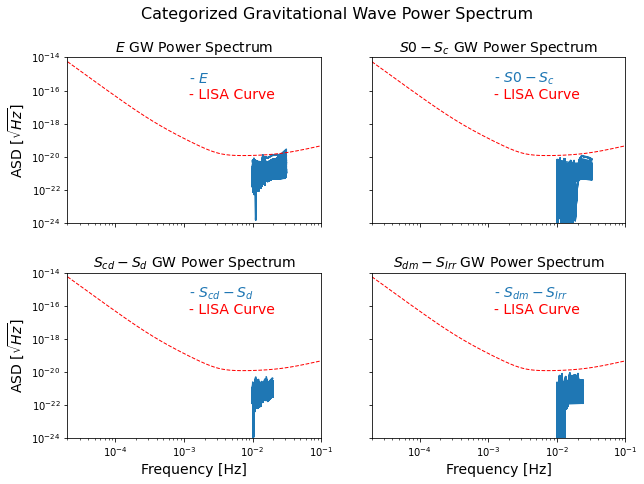

Computing Full Power Spectrum...
Group binaries: 14504 23192 15521 18895 
 Total binaries: 72112
File saved as: full_power_tot_rand.h5
Full Power Spectrum Figure Saved


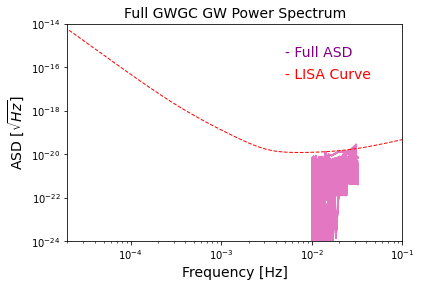

In [111]:
# =========================================
# Plotting Randomized High f Power Spectrum
# (Group and total)
# =========================================

# Import Data
LISA_PSD = GW_calcs.lisa_PSD()
g1_power_tot_rand = pd.read_hdf(data_path + 'group1_power_tot_rand.h5', key='power')
g2_power_tot_rand = pd.read_hdf(data_path + 'group2_power_tot_rand.h5', key='power')
g3_power_tot_rand = pd.read_hdf(data_path + 'group3_power_tot_rand.h5', key='power')
g4_power_tot_rand = pd.read_hdf(data_path + 'group4_power_tot_rand.h5', key='power')

g1_power_tot_rand['ASD'] = (g1_power_tot_rand.strain_2*Tobs*yr_sec)**0.5
g2_power_tot_rand['ASD'] = (g2_power_tot_rand.strain_2*Tobs*yr_sec)**0.5
g3_power_tot_rand['ASD'] = (g3_power_tot_rand.strain_2*Tobs*yr_sec)**0.5
g4_power_tot_rand['ASD'] = (g4_power_tot_rand.strain_2*Tobs*yr_sec)**0.5

g1_power_tot_rand = g1_power_tot_rand[g1_power_tot_rand['ASD'] > 1e-24]
g2_power_tot_rand = g2_power_tot_rand[g2_power_tot_rand['ASD'] > 1e-24]
g3_power_tot_rand = g3_power_tot_rand[g3_power_tot_rand['ASD'] > 1e-24]
g4_power_tot_rand = g4_power_tot_rand[g4_power_tot_rand['ASD'] > 1e-24]


print('Data imported.', '\n')

# Figure Parameters
fs = 14 # fontsize
fig, ((ax1, ax2), 
      (ax3, ax4)) = plt.subplots(2, 2, sharey = False, 
                                 gridspec_kw={'hspace': 0.3, 'wspace': 0.2}, figsize = (10, 7))
fig.suptitle('Categorized Gravitational Wave Power Spectrum', fontsize = fs+2)

# Plotting Style
g_powers_rand = [g1_power_tot_rand, g2_power_tot_rand, g3_power_tot_rand, g4_power_tot_rand]
glx_names = ['$E$', '$S0 - S_c$', '$S_{cd} - S_d$','$S_{dm} - S_{Irr}$']
axs = [ax1, ax2, ax3, ax4]
text_x = 1.2e-3 # text location
text_y_up = 3e-16 # text location
text_y_dn = 3e-17 # text location
fs = 14 # fontsize
ax3.set_xlabel('Frequency [Hz]', fontsize=fs)
ax4.set_xlabel('Frequency [Hz]', fontsize=fs)
ax1.set_ylabel('ASD [$\sqrt{Hz}$]', fontsize=fs)
ax3.set_ylabel('ASD [$\sqrt{Hz}$]', fontsize=fs)

# Plot the Grid
for i in range(4):
    axs[i].plot(g_powers_rand[i].f_gw, 
                g_powers_rand[i].ASD, color='tab:blue', rasterized=True)
    axs[i].plot(np.linspace(5e-6, 0.1, 10000), 
               (LISA_PSD(np.linspace(5e-6, 0.1, 10000)))**0.5, lw=1, linestyle='--', color='red')
    axs[i].set_title(glx_names[i]+' GW Power Spectrum', fontsize=fs)
    axs[i].text(text_x, text_y_up, 
                r'- '+glx_names[i], color = 'tab:blue', fontsize=fs)
    axs[i].text(text_x, text_y_dn, 
                r'- LISA Curve', color = 'red', fontsize=fs)
    print('Plot', i+1, 'done.')

for ax in fig.get_axes():
    ax.label_outer()
    ax.set_xlim(2e-5, 1e-1)
    ax.set_ylim(1e-24, 1e-14)
    ax.set_xscale('log')
    ax.set_yscale('log')

save_plot_name = 'Group_GW_power_spec_rand'
plt.savefig('figures/' + save_plot_name + '.png')
print('Group Power Spectrum Figure Saved.')
plt.show()


# ======================
# Comoputing Total Power
# ======================
print('Computing Full Power Spectrum...')

# Combine all group spectrum
full_power_tot_rand = pd.concat([g1_power_tot_rand, 
                                 g2_power_tot_rand, 
                                 g3_power_tot_rand, 
                                 g4_power_tot_rand])
full_power_tot_rand.sort_values(by=['f_gw'])
print('Group binaries:',
      len(g1_power_tot_rand), 
      len(g2_power_tot_rand), 
      len(g3_power_tot_rand), 
      len(g4_power_tot_rand), '\n',
      'Total binaries:',
      len(full_power_tot_rand))

# Save Data
save_data_path = './DATA/'
full_power_tot_rand.to_hdf(save_data_path + 'full_power_tot_rand' + '.h5', key='power')
print('File saved as:', 'full_power_tot_rand.h5')

# Plotting Total Power
plt.plot(full_power_tot_rand.f_gw, 
         full_power_tot_rand.ASD, color='tab:pink', rasterized=True)
plt.plot(np.linspace(5e-6, 0.1, 10000), 
            (LISA_PSD(np.linspace(5e-6, 0.1, 10000)))**0.5, lw=1, linestyle='--', color='red')

# Plotting Styles
plt.xscale('log')
plt.yscale('log')
plt.xlim(2e-5, 1e-1)
plt.ylim(1e-24, 1e-14)
plt.xlabel('Frequency [Hz]', fontsize=fs)
plt.ylabel('ASD [$\sqrt{Hz}$]', fontsize=fs)

plt.text(0.5e-2, 3e-16, 
         r'- Full ASD', color = 'purple',
         fontsize=fs)
plt.text(0.5e-2, 3e-17, 
         r'- LISA Curve', color = 'red',
         fontsize=fs)
plt.title('Full GWGC GW Power Spectrum',
         fontsize=fs)

save_plot_name = 'Full_GW_power_spec_rand'
plt.savefig('figures/' + save_plot_name + '.png')
print('Full Power Spectrum Figure Saved')
plt.show()

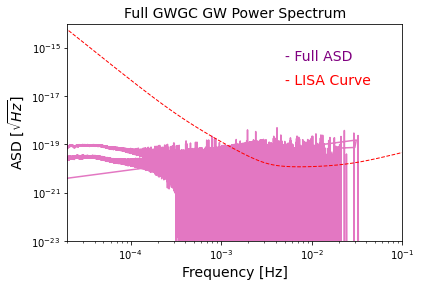

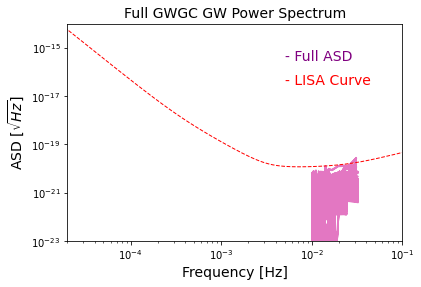

In [112]:
data_path = './DATA/'
full_power_tot = pd.read_hdf(data_path + 'full_power_tot.h5', key='power')
full_power_tot_rand = pd.read_hdf(data_path + 'full_power_tot_rand.h5', key='power')

# Low-frequency part of un-randomized power spectrum
boundary_condition = (full_power_tot_rand.strain_2[0] / full_power_tot.strain_2[-1])**0.5
full_power_tot = full_power_tot[full_power_tot['f_gw'] < 1.1e-2] * boundary_condition

# Plotting Total Power
plt.plot(full_power_tot.f_gw, 
        (full_power_tot.strain_2*Tobs*yr_sec)**0.5, color='tab:purple', rasterized=True)

plt.plot(full_power_tot_rand.f_gw, 
        (full_power_tot_rand.strain_2*Tobs*yr_sec)**0.5, color='tab:pink', rasterized=True)

plt.plot(np.linspace(5e-6, 0.1, 10000), 
            (LISA_PSD(np.linspace(5e-6, 0.1, 10000)))**0.5, lw=1, linestyle='--', color='red')

# Plotting Styles
plt.xscale('log')
plt.yscale('log')
plt.xlim(2e-5, 1e-1)
plt.ylim(1e-23, 1e-14)
plt.xlabel('Frequency [Hz]', fontsize=fs)
plt.ylabel('ASD [$\sqrt{Hz}$]', fontsize=fs)

plt.text(0.5e-2, 3e-16, 
         r'- Full ASD', color = 'purple',
         fontsize=fs)
plt.text(0.5e-2, 3e-17, 
         r'- LISA Curve', color = 'red',
         fontsize=fs)
plt.title('Full GWGC GW Power Spectrum',
         fontsize=fs)
plt.show()

Running Median For Total Power
==

In [6]:
# ================================================
# Power Spectrum Running Median
# ================================================

LISA_PSD = GW_calcs.lisa_PSD()

save_data_path = './DATA/'
full_power_tot = pd.read_hdf(save_data_path + 'full_power_tot.h5', key='power')


# ========== Computing Running Median ================
win = 100 # Running median window width
print('Computing Running Median...')
full_power_tot['hf_2'] = full_power_tot['strain_2']*Tobs*yr_sec
full_PSD_median = full_power_tot.rolling(window=win).median()
full_PSD_median = full_PSD_median[win:]
print('Running Median Done.', '\n')

# ============ Save Running Median Data =============================
print('Saving power running median data...')
full_PSD_median.to_csv(save_data_path + 'full_PSD_median.csv')
print('Running median data saved!')

Computing Running Median...
Running Median Done. 

Saving power running median data...
Running median data saved!


Power and running median data loaded. 

Plotting...
Figure saved as Full_GW_power_median


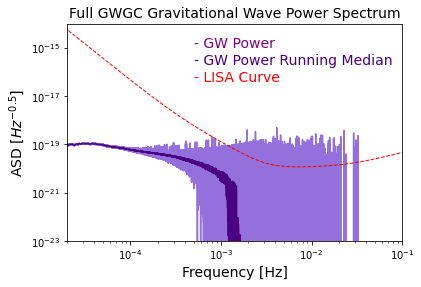

In [7]:
# ===============================================
# Total Power Running Median Plotting
# ===============================================

# Loading power and running median data...
save_data_path = './DATA/'
full_power_tot = pd.read_hdf(save_data_path + 'full_power_tot.h5', key='power')
full_PSD_median = pd.read_csv(save_data_path + 'full_PSD_median.csv')
print('Power and running median data loaded.', '\n')


# Plotting running median
print('Plotting...')
fs = 14 # <====== fontsize

full_power_tot['hf_2'] = full_power_tot['strain_2']*Tobs*yr_sec
plt.plot(full_power_tot.f_gw, full_power_tot.hf_2**0.5, color = 'mediumpurple')
plt.plot(full_PSD_median.f_gw, full_PSD_median.hf_2**0.5, color = 'indigo')

plt.plot(np.linspace(5e-6, 0.1, 10000), 
        (LISA_PSD(np.linspace(5e-6, 0.1, 10000)))**0.5, lw=1, linestyle='--', color='red')

plt.xscale('log')
plt.yscale('log')
plt.xlim(2e-5, 1e-1)
plt.ylim(1e-23, 1e-14)
plt.xlabel('Frequency [Hz]', fontsize=fs)
plt.ylabel('ASD [$Hz^{-0.5}$]', fontsize=fs)
plt.title('Full GWGC Gravitational Wave Power Spectrum', fontsize=fs)

xlabel = 5e-4 # Label x-asix location

plt.text(xlabel, 1e-15, 
         r'- GW Power', color = 'purple', 
         fontsize=fs)
plt.text(xlabel, 2e-16, 
         r'- GW Power Running Median', color = 'indigo', 
         fontsize=fs)
plt.text(xlabel, 4e-17, 
         r'- LISA Curve', color = 'red',
         fontsize=fs)

save_plot_name = 'Full_GW_power_median'
plt.savefig('figures/' + save_plot_name + '.png')
print('Figure saved as', save_plot_name)
plt.show()

Confusion Foreground
===

Power and running median data loaded. 

Computing confusion foreground...
Confusion foreground done. 

Plotting...


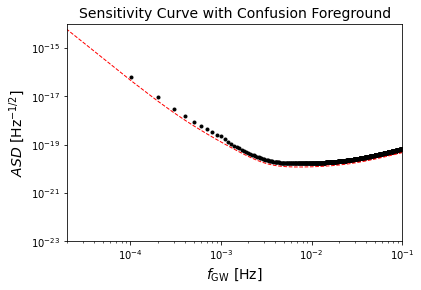

In [3]:
# ===============================================
# Computing Confusion Foreground
# ===============================================

# Loading power and running median data...
save_data_path = './DATA/'
full_power_tot = pd.read_hdf(save_data_path + 'full_power_tot.h5', key='power')
full_PSD_median = pd.read_csv(save_data_path + 'full_PSD_median.csv')
full_power_tot['hf_2'] = full_power_tot['strain_2']*Tobs*yr_sec
print('Power and running median data loaded.', '\n')


print('Computing confusion foreground...')
LISA_noise_median = LISA_PSD(full_PSD_median.f_gw)
full_PSD_median['hf_2'] = full_PSD_median['hf_2'] + LISA_noise_median

# Adding boundaries above and below to the foreground frequencies to compute SNRs
# (In case the frequency band is not complete)

PSD_median = full_PSD_median[['f_gw', 'hf_2']]

f_gw_add_up = np.linspace(0.1, 1, 1000)     # Upper boundry
f_gw_add_lo = np.linspace(1e-8, 1e-7, 1000) # Lower boundry

f_gw_add = np.append(f_gw_add_up, f_gw_add_lo)
PSD_median_noise_add = LISA_PSD(f_gw_add)

PSD_median = PSD_median.append(pd.DataFrame(np.vstack([f_gw_add, PSD_median_noise_add]).T, 
                                            columns=['f_gw', 'hf_2']))
extraglc_background_interp = interp1d(PSD_median.f_gw, PSD_median.hf_2)
print('Confusion foreground done.', '\n')

# ======== Import COSMIC MW Confusion Foreground ========================
COSMIC_MW_foreground = pd.read_csv('COSMIC_MW_foreground.csv')
mw_foregound_interp = interp1d(COSMIC_MW_foreground.f_gw, COSMIC_MW_foreground.hf_2)

# Combine Milky-Way and Extragalactic

background_PSD = (extraglc_background_interp(np.linspace(1e-8, 1, 10000)) +
                  mw_foregound_interp(np.linspace(1e-8, 1, 10000)))    
background_interp = interp1d(np.linspace(1e-8, 1, 10000), background_PSD)


# ======== Background_interp plotting =============================================
print('Plotting...')
fs = 14 # <====== fontsize

plt.plot(np.linspace(1e-8, 1, 10000), 
            (background_interp(np.linspace(1e-8, 1, 10000)))**0.5, 'k.', color='black')

plt.plot(np.linspace(1e-8, 1, 10000), 
        (LISA_PSD(np.linspace(1e-8, 1, 10000)))**0.5, 
         lw=1, linestyle='--', color='red')

plt.yscale('log')
plt.xscale('log')
plt.xlabel(r'$f_{\rm{GW}}$ [Hz]', size=fs)
plt.ylabel(r'$ASD$ [Hz$^{-1/2}$]', size=fs)
plt.title('Sensitivity Curve with Confusion Foreground', fontsize=fs)
plt.xlim(2e-5, 1e-1)
plt.ylim(1e-23, 1e-14)

plt.show()

SNR and Resolveable Sources
===

In [ ]:
# ===============================================
# ====== Find Resolvable Sources ================
# ===============================================


# Loading power and running median data...
save_data_path = './DATA/'
full_power_tot = pd.read_hdf(save_data_path + 'full_power_tot.h5', key='power')
full_PSD_median = pd.read_csv(save_data_path + 'full_PSD_median.csv')
full_power_tot['hf_2'] = full_power_tot['strain_2']*Tobs*yr_sec
print('Power and running median data loaded.', '\n')


# Loud source condition: SNR > 7
Tobs=10
SNR_lim = 7
dat_loud = []
dat_loud = full_power_tot.loc[full_power_tot.strain_2*Tobs*yr_sec/4 > 
                              SNR_lim * background_interp(full_power_tot.f_gw)]
print('Loud systems: {}'.format(len(dat_loud)))


# Plotting
fs = 14 # <====== fontsize

#plt.plot(full_power_tot.f_gw, 
#        (full_power_tot.strain_2*Tobs*yr_sec)**0.5, color='mediumpurple')

plt.plot(dat_loud.f_gw, (dat_loud.strain_2*Tobs*yr_sec)**0.5,
         '.', markersize = 4, color='indigo')

plt.plot(np.linspace(1e-8, 1, 10000), 
    (background_interp(np.linspace(1e-8, 1, 10000)))**0.5, lw=1, color='black')

plt.yscale('log')
plt.xscale('log')
plt.xlim(2e-5, 1e-1)
plt.ylim(1e-23, 1e-14)
plt.xlabel(r'$f_{\rm{GW}}$ [Hz]', size=fs)
plt.ylabel(r'$ASD$ [Hz$^{-1/2}$]', size=fs)
plt.title('Sensitivity Curve with Resolvable Sources', fontsize=fs+2)

plt.show()